In [1]:
import codecs
import json
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import yaml

<IPython.core.display.Javascript object>


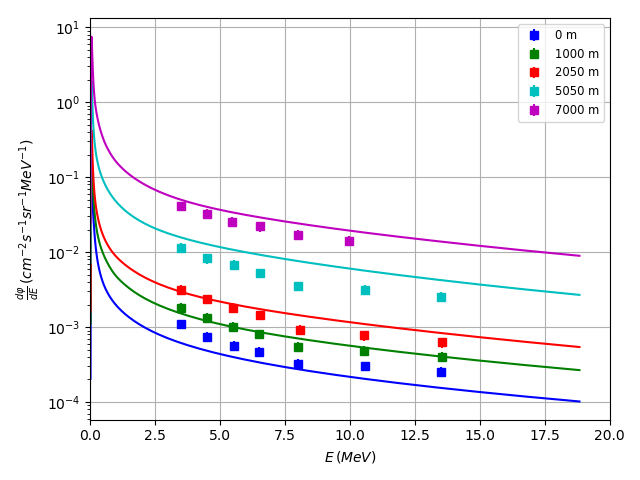

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)
energy_label = r'$E \, (MeV)$'
ax.set_xlabel(energy_label)
diff_intensity_label = r"$\frac{d \varphi}{d E} \, (cm^{-2} s^{-1} sr^{-1} MeV^{-1})$"
ax.set_ylabel(diff_intensity_label);  

Figure 1: The differential intensity of downward moving gamma rays at altitudes shown in the legend, as calculated by the Jabiru API and as measured by a Sodium Iodide spectrometer [1]

[1] Cecchini, S., Chiarusi, T., Pagliarin, A., & Giovanni, G. (2005). On the altitude dependence of gamma-rays spectra in the Earth's atmosphere. In International Cosmic Ray Conference (Vol. 2, p. 349).

In [3]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [4]:
# construct the target API URL
hostname = "https://api.amentum.space"

api_url = hostname + "/api/get_differential_intensity?"
api_url += "particle=gamma&"
api_url += "angle=1.0&"

# this study contains results from experiments on different dates and locations, so other parameters are set in the loop 

In [5]:
reader = codecs.getreader("utf-8")

In [6]:
# read the experimental data from YAML file
with open('./gamma_cecchini.yaml') as f : doc = yaml.load(f)
f.close()

In [7]:
for i,plot in enumerate(doc['plots']):

    # analyse and plot the reference data from Cecchini paper
    data = np.array(plot['data'])

    altitude = plot['altitude']['value']

    kes = data.T[0]
    fluxes = data.T[1]

    kes_triplets = kes.reshape(-1,3)
    fluxes_triplets = fluxes.reshape(-1,3)

    kes = [d[1] for d in kes_triplets]
    
    low_fluxes = np.array([d[0] for d in fluxes_triplets])
    mean_fluxes = np.array([d[1] for d in fluxes_triplets])
    high_fluxes = np.array([d[2] for d in fluxes_triplets])

    low_fluxes = mean_fluxes - low_fluxes
    high_fluxes = high_fluxes - mean_fluxes

    plt.errorbar(kes  # MeV
                , mean_fluxes  # /cm2/s/sr/MeV
                , yerr=[low_fluxes, high_fluxes] # ditto
                , linestyle = "None"
                , marker = "s"
                , label = np.str(altitude) + " m"
                , color = colors[i])
    
    # initialise the Jabiru API target URL for this dataset
    this_url = api_url
    
    # convert altitude from m to km
    altitude /= 1000.0
    temp_param = "altitude="+str(altitude)+"&"
    this_url += temp_param
    
    year = plot['year']
    temp_param = "year="+str(year)+"&"
    this_url += temp_param
    
    # month and day are not given in the published data, we assume the 1st of Jan 
    # TODO update if/when further information is provided
    this_url += "month=1&"
    this_url += "day=1&"
    
    latitude = plot['latitude']['value']
    if plot['latitude']['units'] == "S": latitude *= -1.0 
        
    temp_param = "latitude="+str(latitude)+"&"
    this_url += temp_param
    
    longitude = plot['longitude']['value']
    if plot['longitude']['units'] == "W": latitude *= -1.0 
        
    temp_param = "longitude="+str(longitude)+"&"
    this_url += temp_param
    
    # hit the Jabiru API and fetch the proton intensity data
    try:
        response = urllib.request.urlopen(this_url)
    except urllib.error.URLError as e: 
        ResponseData = e.reason
        print("ERROR: ", ResponseData)
    
    json_payload = json.load(reader(response))

    #
    kes = json_payload["energies"]["data"] # MeV
    flux = json_payload["intensities"]["data"] # /cm2/s/sr/MeV
    
    # JABIRU will return energies up to 10GeV, so we crop the data for this comparison
    max_kei = np.searchsorted(kes, 20)# MeV
    
    kes = kes[:max_kei]
    flux = flux[:max_kei]
    
    ax.plot(kes # MeV
        , flux  #
        , linestyle = "-"
        , marker = "None"
        , color = colors[i])

In [8]:
ax.semilogy()
ax.grid()
ax.set_xlim(xmin = 0, xmax=20)# MeV
ax.legend(loc="upper right", fontsize = 'small', numpoints = 1)
plt.tight_layout()
plt.savefig("gamma_cecchini.png")


/home/iwan/anaconda3/envs/amentum/lib/python3.7/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/iwan/anaconda3/envs/amentum/lib/python3.7/site-packages/matplotlib/axes/_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
